In [8]:
import nltk
import json
from nltk.corpus import stopwords
import re
import string

import pandas as pd
import urllib
from urllib.parse   import quote
from urllib.request import urlopen
import codecs

# Words that characterise the parties

## _Exercise 2_: TF-IDF and the Republican and Democratic parties.

- First, check out the wikipedia page for TF-IDF. Explain in your own words the point of TF-IDF.
    - What does TF stand for?
        - _Term frequency._ Number of ocurrences of a word in a given document.
 
    - What does IDF stand for?
        - _Inverse document frequency._ Logarithmic fraction of the total number of documents by the number of documents containing the term.
        
             _Is the numerical representation of the importance of a word in a corpus. For our interests in text analysis, it's a weighting factor._


- Since we want to find out which words are important for each party, so we're going to create two large documents, one for the Democratic and one for the Republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party. Remember the bullets below for success.
    - If you dont' know what tokenization means, go back and read Chapter 3 again. The advice to go back and check Chapter 3 is valid for every cleaning step below.
    - Exclude the congress members names (since we're interested in the words, not the names).
    - Exclude punctuation.
    - Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
    - Exclude numbers (since they're difficult to interpret in the word cloud).
    - Set everything to lower case.

1. We import all the congressmen and split them in two sets: Republicans and Democrats.

In [2]:
cong115 = pd.read_csv('../socialgraphs2018/files/data_US_congress/H115.csv', encoding='utf-8')

republican_congressmen, democrat_congressmen = set(), set()

for cm in cong115['WikiPageName']:
    cm_1 = nltk.word_tokenize(cm.replace("_", " "))
    if cong115[cong115.WikiPageName == cm].Party.item() == 'Republican':
        for t in cm_1:
            republican_congressmen.add(t)
    else:
        for t in cm_1:
            democrat_congressmen.add(t)
congressmen = republican_congressmen.union(democrat_congressmen)

2. We take every word in the Wikipedia page of every congressman removing the types specified in the exercise. And separate the words depending on the member's political afiliation.

In [22]:

baseurl = "http://en.wikipedia.org/w/api.php/?"
action = "action=query"
content = "prop=extracts&exlimit=max&explaintext"
rvprop ="rvprop=timestamp|content"
dataformat = "format=json"
rvdir = "rvdir=older" #sort revisions from newest to oldest
start = "rvend=2000-01-03T00:00:00Z" #start of my time period
end = "rvstart=2015-01-03T00:00:00Z" #end of my time period
limit = "rvlimit=1" #consider only the first revision
html = ''

tokens_dem = []
tokens_rep = []

for wikiPage in cong115['WikiPageName']:
    nm = quote(wikiPage, safe='. ')
    title = "titles=%s"  % nm
    #title = quote("titles=", safe='/=_ e')
    query = "%s%s&%s&%s&%s&%s&%s&%s&%s&%s" % (baseurl, action, title, content,
                                          rvprop, dataformat, rvdir, end,
                                          start, limit)

    html = urlopen(query).read()
    j = json.loads(html.decode('utf-8'))
    k = [k for k in j['query']['pages'].keys()][0]
    
    extract = j['query']['pages'][k]['extract']

    #tokenised content
    tok_extract = nltk.word_tokenize(extract)
    tokens = [w for w in tok_extract if re.search(r'\w',w)]
    tok_extract = [w.lower() for w in tok_extract if w not in congressmen]
    tok_extract = [w for w in tok_extract if w not in stopwords.words('english')]
    tok_extract = [w for w in tok_extract if not re.search(r'[.,\/#!$%\^&\*;:{}=\-\—_`~()\']', w)]
    tok_extract = [w for w in tok_extract if not re.search(r'\s|(===)|(==)|\d+(\.\d+)?', w)]
    #tok_extract = [re.sub(r'[^a-zA-Z0-9]+', "", w) for w in tok_extract]

#    with open('../Representatives_NL/115/%s.txt' % wikiPage, 'w+', encoding='utf-8') as f:
#        f.write(html.decode('utf-8'))
#        f.close()
    #print("DEM", tokens_dem)
    #print("REP", tokens_rep)
    if cong115[cong115.WikiPageName == wikiPage].Party.item() == 'Republican':
        file = open("../data/republicans.txt","w")
        file.write(" ".join(tok_extract))
        #tokens_rep.extend(tok_extract)
        #print(tokens_rep)
    else:
        file = open("../data/democrats.txt","w")
        file.write(" ".join(tok_extract))
        #tokens_dem.extend(tok_extract)
        #print(tokens_dem)
    print(wikiPage)
    file.close()
#print("REP", tokens_rep)
#print("DEM", tokens_dem)

John_Conyers
Don_Young
Jim_Sensenbrenner
Hal_Rogers
Chris_Smith_(New_Jersey_politician)
Steny_Hoyer
Marcy_Kaptur
Sander_Levin
Joe_Barton
Pete_Visclosky
Peter_DeFazio
John_Lewis_(civil_rights_leader)
Louise_Slaughter
Lamar_Smith
Fred_Upton
Nancy_Pelosi
Jimmy_Duncan_(politician)
Frank_Pallone
Eliot_Engel
Nita_Lowey
Richard_Neal
Dana_Rohrabacher
Ileana_Ros-Lehtinen
José_E._Serrano
David_Price_(American_politician)
Rosa_DeLauro
Collin_Peterson
Maxine_Waters
Sam_Johnson
Jerrold_Nadler
Jim_Cooper
Xavier_Becerra
Sanford_Bishop
Ken_Calvert
Jim_Clyburn
Anna_Eshoo
Bob_Goodlatte
Gene_Green
Luis_Gutiérrez
Alcee_Hastings
Eddie_Bernice_Johnson
Peter_T._King
Carolyn_Maloney
Lucille_Roybal-Allard
Ed_Royce
Bobby_Rush
Bobby_Scott_(politician)
Nydia_Velázquez
Bennie_Thompson
Frank_Lucas_(Oklahoma_politician)
Lloyd_Doggett
Michael_F._Doyle
Rodney_Frelinghuysen
Sheila_Jackson_Lee
Walter_B._Jones_Jr.
Frank_LoBiondo
Zoe_Lofgren
Mac_Thornberry
Elijah_Cummings
Earl_Blumenauer
Robert_Aderholt
Kevin_Brady
Danny_

- Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each party.
    - Describe similarities and differences between the parties.
        - _The most common words relate to personal information such as member's origin, i.e. district._
    - Why aren't the TFs not necessarily a good description of the parties?
        - _Despite the words appear, unless we get more context we cannot be sure of if they are supporting or criticising a certain topic._

In [24]:
dem = open("../data/democrats.txt","r").read()
dem_words = nltk.word_tokenize(dem)
dem_text = nltk.Text(dem_words)

rep = open("../data/republicans.txt","r").read()
rep_words = nltk.word_tokenize(rep)
rep_text = nltk.Text(rep_words)


fd_dem = nltk.FreqDist(dem_text)
fd_rep = nltk.FreqDist(rep_text)
print('Top 5 democratic words: ', fd_dem.most_common(5))
print('Top 5 republican words: ', fd_rep.most_common(5))

Top 5 democratic words:  [('district', 14), ('election', 13), ('heroin', 10), ('federal', 9), ('republican', 8)]
Top 5 republican words:  [('election', 11), ('senate', 9), ('committee', 8), ('district', 6), ('house', 6)]


- Next, we calculate IDF for every word.
    - What base logarithm did you use? Is that important?
        - _I used base 10. It is not really important as long as it is compatible with other statistic we calculate._

In [29]:
from math import log

for e in fd_dem.most_common(5):
    print(e[0] + " : " + str(log(len(dem_words) / int(e[1]))))

for e in fd_rep.most_common(5):
    print(e[0] + " : " + str(log(len(rep_words) / int(e[1]))))

district : 4.155529251261241
election : 4.229637223414962
heroin : 4.492001487882454
federal : 4.59736200354028
republican : 4.715145039196663
election : 3.29246418152569
senate : 3.493134876987841
committee : 3.6109179126442243
district : 3.8985999850960056
house : 3.8985999850960056


- We're ready to calculate TF-IDF. Do that for each party.
    - List the 10 top words for each party.
    - Are these 10 words more descriptive of the party? If yes, what is it about IDF that makes the words more informative?
        - _Most of them are not descriptive of the party. The few that are descriptive remain in the second half of the top 10._
- Normally, TF-IDF is used for single documents. What does TF-IDF tell us about the content of a single document in a collection.
    - _That tells less information thus a single document may not cover all the contents but just a topic, leaving relevant words out of sight when looking for the most used across a collection._

In [30]:
print('Top 10 democratic words: ', fd_dem.most_common(10))
print('Top 10 republican words: ', fd_rep.most_common(10))

Top 10 democratic words:  [('district', 14), ('election', 13), ('heroin', 10), ('federal', 9), ('republican', 8), ('pittsburgh', 8), ('sentenced', 8), ('congressional', 7), ('special', 7), ('votes', 7)]
Top 10 republican words:  [('election', 11), ('senate', 9), ('committee', 8), ('district', 6), ('house', 6), ('subcommittee', 6), ('state', 5), ('term', 5), ('seat', 5), ('energy', 5)]


# The word cloud

## Exercise 3 (word-cloud edition)

> - The package needs a string to work on. The way that I converted my TF-IDF results to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its TF-IDF score (rounded up to the nearest integer value).
- Now, create word-cloud for each party. Feel free to make it as fancy or non-fancy as you like. Comment on the results.

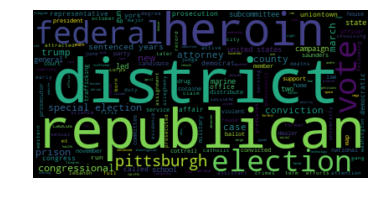

In [36]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def drawWordCloud(text):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

drawWordCloud(dem)

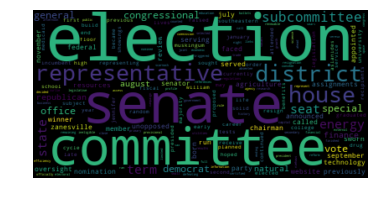

In [37]:
drawWordCloud(rep)

- _This visualization helps to stand out the most important words while making it really hard to see the least used. Eye-catchy as it is provides valuable information skipping the numbers which can sometimes be interesting._

# Community detection

- Community
    - Densely connected group
    - $e _{ij} $: edge connecting community i to community j.
    - $a_i$: sum of all the edges.
- Modularity
    - Measures how good interconnection between communities is.

- k-cliques:
    - clique: fully connected subgraph.
    - A k-clique community is a bunch of adjacent k cliques.
    - Shows that each node should be able to be a member of different communities.
- Strong community:
    - Every node has more connections inside the community than outside.
- Link communities:
    - Any node is in many communities.
    - Discards that strong communities are weak against other communities thus nodes can be members of many communities.

> _Exercise 8_: Use the concept of modularity to explore how community-like the parties and states are.
- Explain the concept of modularity in your own words.
    - _Measurement of how good interconnection between communities is._
- Consider the undirected version of the graph for the 115th house of representatives.

In [38]:
import networkx as nx
import io

congress115 = pd.read_csv('../data/H115.csv')
path_folder = "../data/Representatives/115/"

congress115_graph = nx.Graph()
for cm in congress115.WikiPageName.sort_values():
    
    #new node corresponding with new congressman
    congress115_graph.add_node(cm,
                              state=congress115[congress115.WikiPageName == cm].State,
                              party=congress115[congress115.WikiPageName == cm].Party )
    
    f = io.open(path_folder+cm+'.txt', 'r', encoding='utf-8').read()
    links = re.findall("\[\[(.*?)\]\]", f)
    links_simple = list()
    wikilink_rx = re.compile(r'\[\[(?:[^|\]]*)\|?([^\]]+)\]\]')
    for l in links:
        match = re.search(r'([a-zA-Z0-9_\s\(\)\-\,.]*)\|([a-zA-Z0-9_\s\(\)\-\,.]*)', l)
        if match == None:
            m = l.replace(" ", "_")
            if m in set(congress115.WikiPageName):
                congress115_graph.add_edge(cm, m)
        else:
            m1 = match.group(1).replace(" ", "_")
            m2 = match.group(2).replace(" ", "_")
            if m1 in set(congress115.WikiPageName):
                congress115_graph.add_edge(cm, m1)
            if m2 in set(congress115.WikiPageName):
                congress115_graph.add_edge(cm, m2)

>- Compute the modularity when you partition nodes based on their party. Modularity is described in the Network Science book, section 9.4). Use equation 9.12 in the book to calculate the modularity M of the parties-partitioning. Are the parties good community?
    - _Yes, they are. Low modularity indicates well connected communities thus parties are good communities. (See result below)_

In [39]:
L = len(congress115_graph.edges()) #Total amount of edges
L_rep, L_dem = 0, 0

for edge in congress115_graph.edges():
    if congress115[congress115.WikiPageName == edge[0]].Party.values[0] == congress115[congress115.WikiPageName == edge[1]].Party.values[0] == 'Republican':
        L_rep += 1
    elif congress115[congress115.WikiPageName == edge[0]].Party.values[0] == congress115[congress115.WikiPageName == edge[1]].Party.values[0] == 'Democratic':
        L_dem += 1

K_rep, K_dem = 0, 0
for elt in list(congress115_graph.degree()):
    if congress115[congress115.WikiPageName == elt[0]].Party.values[0] == 'Republican':
        K_rep += elt[1]
    else:
        K_dem += elt[1]

In [40]:
modularity = (L_rep/L - pow(K_rep/(2*L),2)) + (L_dem/L - pow(K_dem/(2*L),2))
print(modularity)

0.1446068139189832


> - Repeat the exercise above by considering states instead of parties. Are the states good communities?
- Would you expect these results in light of what we have found in the previous exercises?

# TODO: I will do that if I have time


>_Exercise 9_: Community detection on the house of representatives network.
- Use the Python Louvain-algorithm implementation to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the parties/states as communities? What does this comparison reveal about the parties/states?
    - You can also try the Infomap algorithm instead if you're curious. Go to [this page]. (http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.

In [48]:
import community

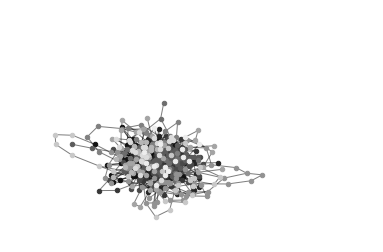

In [51]:
partition = community.best_partition(congress115_graph)

size = float(len(set(partition.values())))
pos = nx.spring_layout(congress115_graph)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(congress115_graph, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(congress115_graph,pos, alpha=0.5)
plt.axis('off')
plt.show()